# Edgar Sabán - 19012631

# Lab 2

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [1]:
# Importando librerías

import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

%reload_ext tensorboard

tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


## Preparación y exploración de los datos

In [2]:
# Obtención de datos
dtCovid = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dtCovid

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,93272,93288,96531,98734,98734,98734,103902,105749,107957,109532
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,132469,132476,132481,132484,132488,132490,132490,132496,132497,132499
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,134115,134458,134840,135219,135586,135821,136294,136679,137049,137403
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,13828,13836,13839,13842,13842,13842,13864,13864,13873,13877
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,36921,37094,37289,37467,37604,37678,37748,37874,38002,38091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,11304,11794,12150,12508,12978,13258,13530,13782,13989,14323
275,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,311948,312164,312334,312499,312605,312673,312811,313015,313015,313015
276,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,6864,6867,6869,6875,6877,6885,6889,6892,6898,6905
277,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,115824,118850,122244,125157,126973,129033,130631,133659,137026,140620


Se puede observar que las fechas están como columnas y están incluidas las del año 2020 hasta la fecha (2021). Para este análisis se tomarán los datos del año 2021 hasta el mes de abril.

In [3]:
# Transformación de los datos
dtCovidGT = dtCovid.drop(['Lat','Long'], axis = 1)
dtCovidGT = dtCovidGT.melt(id_vars=['Country/Region','Province/State'])
dtCovidGT = dtCovidGT[dtCovidGT['Country/Region'] == 'Guatemala']
dtCovidGT.rename(columns = {'variable':'fecha', 'value':'confirmados'}, inplace = True)
dtCovidGT.head()

,Country/Region,Province/State,fecha,confirmados
138,Guatemala,NaN,1/22/20,0
417,Guatemala,NaN,1/23/20,0
696,Guatemala,NaN,1/24/20,0
975,Guatemala,NaN,1/25/20,0
1254,Guatemala,NaN,1/26/20,0


In [4]:
# Conviertiendo fecha a tipo de dato date
dtCovidGT['fecha'] = pd.to_datetime(dtCovidGT['fecha'],infer_datetime_format = True)
dtCovidGT.head()

,Country/Region,Province/State,fecha,confirmados
138,Guatemala,NaN,2020-01-22,0
417,Guatemala,NaN,2020-01-23,0
696,Guatemala,NaN,2020-01-24,0
975,Guatemala,NaN,2020-01-25,0
1254,Guatemala,NaN,2020-01-26,0


In [5]:
# Seleccionando fechas entre enero y diciembre y casos confirmados
dtCovidGT = dtCovidGT[(dtCovidGT['fecha'] > '2020-01-31') &
                      (dtCovidGT['fecha'] <= '2020-12-31') &
                      (dtCovidGT['confirmados'] > 0)]
dtCovidGT.head()

,Country/Region,Province/State,fecha,confirmados
14646,Guatemala,NaN,2020-03-14,1
14925,Guatemala,NaN,2020-03-15,1
15204,Guatemala,NaN,2020-03-16,2
15483,Guatemala,NaN,2020-03-17,6
15762,Guatemala,NaN,2020-03-18,6


In [7]:
# Conversión de fechas a números
dtCovidGT['no_dia'] = np.linspace(start = 0,
                                 stop = len(dtCovidGT['fecha']),
                                 num = len(dtCovidGT['fecha']),
                                 dtype = int)
dtCovidGT.head()

,Country/Region,Province/State,fecha,confirmados,no_dia
14646,Guatemala,NaN,2020-03-14,1,0
14925,Guatemala,NaN,2020-03-15,1,1
15204,Guatemala,NaN,2020-03-16,2,2
15483,Guatemala,NaN,2020-03-17,6,3
15762,Guatemala,NaN,2020-03-18,6,4


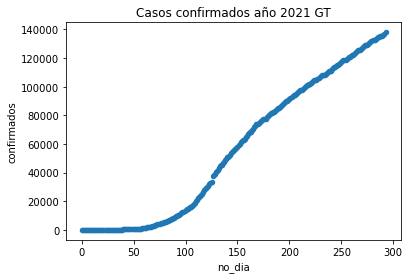

In [8]:
# Se grafican los resultados para ver la tendencia de confirmados
dtCovidGT.plot.scatter(x = 'no_dia', y = 'confirmados')
plt.title('Casos confirmados año 2021 GT')
plt.show()

Para la creación de un modelo exponencial es necesario cambiar la escala de los valores de confirmados y convertirlos a logaritmo

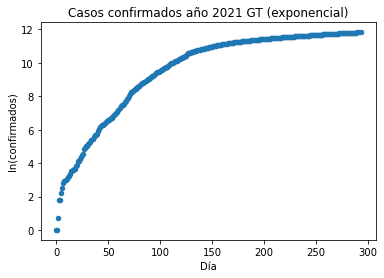

In [9]:
dtCovidGT["ln(confirmados)"] = np.log(dtCovidGT['confirmados'])
dtCovidGT.plot.scatter(x = 'no_dia', y = 'ln(confirmados)')
plt.title('Casos confirmados año 2021 GT (exponencial)')
plt.xlabel('Día')
plt.show()

**Nota**: Anteriormente se indicó que para el análisis se tomarían los datos del año 2021, sin embargo al explorarlo se pudo observar que durante el año 2021 los número de confirmados con Covid seguían una tendencia constante, por lo cual no generaba mayor impacto realizar predicciones sobre ello, por lo cual se tomaron los datos del año 2020, y la tendencia es creciente por lo cual se puede realizar un modelo exponencial sobre estos datos.

## Modelo de regresión lineal

A continuación se implementa un modelo de regresión lineal basado en gradient descent con tensorflow. Este código fue obtenido del laboratorio 1.

In [10]:
# MRL = modelo de regresión lineal
class MRL:
    
    # Constructor de clase para la inicialización de los parámetros
    def __init__ (self):
        self.parametros = tf.get_variable("parametros", dtype = tf.float32, shape = [1,2], initializer = tf.zeros_initializer())
    
    # Cálculo de MSE
    def MSE(self, x, y):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - tf.matmul(self.parametros,x)))
        return error

    # Cálculo de  gradient descent
    def gradient_descent(self, x, y, lr):
        mse = self.MSE(x,y)
        error_summary = tf.summary.scalar("mse_summary", mse)
        gradiente = tf.gradients(mse, [self.parametros])
        new_w = tf.assign(self.parametros, self.parametros -lr * gradiente[0])
        return new_w, mse, error_summary

In [11]:
def training_model(x, y, lr, epochs, printl):

    # String para experimento
    string = './logs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_epochs="+str(epochs)+"_lr="+str(lr)

    # Definición del grafo
    graph = tf.Graph()
    with graph.as_default():
        
        # Creación de los tensores input
        tx = tf.placeholder(tf.float32, [2,None], "tx")
        ty = tf.placeholder(tf.float32, [None], "ty")
        
        # Creación del nodo para el cálculo de los nuevos parámetros según gradient_descent
        mrl = MRL()
        nuevos_parametros = mrl.gradient_descent(tx, ty, lr)
        
        # Writer para utilizacion de tensorboard
        writer = tf.summary.FileWriter(string, graph)
        
        # Ejecución del grafo
        with tf.train.MonitoredSession() as session:
            # Paso de valores a los tensores input
            tensor_dict = {tx:x, ty:y}
            
            # Ejecución de epochs + 1 veces del algoritmo
            for i in range(epochs + 1):
                # Entrenamiento del modelo para cálculo de los nuevos parámetros
                entrenamiento = session.run(nuevos_parametros, feed_dict = tensor_dict)
                # Imprimiendo los epoch según el printl
                if i % printl == 0:
                    parametros = session.run(mrl.parametros, feed_dict = tensor_dict)
                    # Agregar datos a writer para poder visualizarlos en tensorboard
                    writer.add_summary(entrenamiento[2], i)
                    print("Epoch: ", i, "Parámetros: ", parametros, "mse: ", entrenamiento[1])
                    
            writer.close()
    return entrenamiento

### Experimentos

In [12]:
# Preparando los datos para entrenamiento

# Preparando X y Y para entrenar modelo
x = dtCovidGT['no_dia']
# Se agrega un 1 a X para que pueda realizarse los cálculos del gradiente descent
x = np.array([x, np.ones_like(x)], dtype = "float64")
y = dtCovidGT['ln(confirmados)']

In [13]:
# Experimento 1
training_model(x, y, 0.01, 1000, 100)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[15.944154    0.09505627]] mse:  49.03856
Epoch:  100 Parámetros:  [[nan nan]] mse:  nan
Epoch:  200 Parámetros:  [[nan nan]] mse:  nan
Epoch:  300 Parámetros:  [[nan nan]] mse:  nan
Epoch:  400 Parámetros:  [[nan nan]] mse:  nan
Epoch:  500 Parámetros:  [[nan nan]] mse:  nan
Epoch:  600 Parámetros:  [[nan nan]] mse:  nan
Epoch:  700 Parámetros:  [[nan nan]] mse:  nan
Epoch:  800 Parámetros:  [[nan nan]] mse:  nan
Epoch:  900 Parámetros:  [[nan nan]] mse:  nan
Epoch:  1000 Parámetros:  [[nan nan]] mse:  nan


(array([[nan, nan]], dtype=float32),
 nan,
 b'\n\x12\n\x0bmse_summary\x15\x00\x00\xc0\x7f')

In [14]:
# Experimento 2
training_model(x, y, 0.01, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[15.944154    0.09505627]] mse:  49.03856
Epoch:  10 Parámetros:  [[5.3714143e+25 2.7544673e+23]] mse:  inf
Epoch:  20 Parámetros:  [[nan nan]] mse:  nan
Epoch:  30 Parámetros:  [[nan nan]] mse:  nan
Epoch:  40 Parámetros:  [[nan nan]] mse:  nan
Epoch:  50 Parámetros:  [[nan nan]] mse:  nan
Epoch:  60 Parámetros:  [[nan nan]] mse:  nan
Epoch:  70 Parámetros:  [[nan nan]] mse:  nan
Epoch:  80 Parámetros:  [[nan nan]] mse:  nan
Epoch:  90 Parámetros:  [[nan nan]] mse:  nan
Epoch:  100 Parámetros:  [[nan nan]] mse:  nan


(array([[nan, nan]], dtype=float32),
 nan,
 b'\n\x12\n\x0bmse_summary\x15\x00\x00\xc0\x7f')

In [15]:
# Experimento 3
training_model(x, y, 0.001, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[1.5944154  0.00950563]] mse:  49.03856
Epoch:  10 Parámetros:  [[3.7678758e+14 1.9321709e+12]] mse:  2.6779345e+30
Epoch:  20 Parámetros:  [[9.2282059e+28 4.7322333e+26]] mse:  inf
Epoch:  30 Parámetros:  [[nan nan]] mse:  nan
Epoch:  40 Parámetros:  [[nan nan]] mse:  nan
Epoch:  50 Parámetros:  [[nan nan]] mse:  nan
Epoch:  60 Parámetros:  [[nan nan]] mse:  nan
Epoch:  70 Parámetros:  [[nan nan]] mse:  nan
Epoch:  80 Parámetros:  [[nan nan]] mse:  nan
Epoch:  90 Parámetros:  [[nan nan]] mse:  nan
Epoch:  100 Parámetros:  [[nan nan]] mse:  nan


(array([[nan, nan]], dtype=float32),
 nan,
 b'\n\x12\n\x0bmse_summary\x15\x00\x00\xc0\x7f')

In [16]:
# Experimento 4
training_model(x, y, 0.0001, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[0.15944153 0.00095056]] mse:  49.03856
Epoch:  10 Parámetros:  [[47.921143    0.24720235]] mse:  9558442.0
Epoch:  20 Parámetros:  [[22147.992     113.57795]] mse:  2046513000000.0
Epoch:  30 Parámetros:  [[10248186.      52552.81]] mse:  4.381693e+17
Epoch:  40 Parámetros:  [[4.7419976e+09 2.4317020e+07]] mse:  9.3814655e+22
Epoch:  50 Parámetros:  [[2.1941963e+12 1.1251864e+10]] mse:  2.0086246e+28
Epoch:  60 Parámetros:  [[1.0152885e+15 5.2064095e+12]] mse:  4.3005786e+33
Epoch:  70 Parámetros:  [[4.6978978e+17 2.4090874e+15]] mse:  inf
Epoch:  80 Parámetros:  [[2.1737894e+20 1.1147216e+18]] mse:  inf
Epoch:  90 Parámetros:  [[1.0058459e+23 5.1579906e+20]] mse:  inf
Epoch:  100 Parámetros:  [[4.6542048e+25 2.3866808e+23]] mse:  inf


(array([[4.6542048e+25, 2.3866808e+23]], dtype=float32),
 inf,
 b'\n\x12\n\x0bmse_summary\x15\x00\x00\x80\x7f')

In [17]:
# Experimento 5
parametros = training_model(x, y, 0.00007, 400000, 50000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 Parámetros:  [[0.11160908 0.00066539]] mse:  49.03856
Epoch:  50000 Parámetros:  [[0.04012712 3.0952625 ]] mse:  1.4840051
Epoch:  100000 Parámetros:  [[0.03354121 4.3795657 ]] mse:  0.9827127
Epoch:  150000 Parámetros:  [[0.03080897 4.9123707 ]] mse:  0.8964009
Epoch:  200000 Parámetros:  [[0.02967541 5.1334243 ]] mse:  0.8815309
Epoch:  250000 Parámetros:  [[0.02920406 5.22534   ]] mse:  0.8789623
Epoch:  300000 Parámetros:  [[0.02901871 5.261483  ]] mse:  0.878534
Epoch:  350000 Parámetros:  [[0.02893851 5.2771063 ]] mse:  0.87845033
Epoch:  400000 Parámetros:  [[0.02893851 5.2771063 ]] mse:  0.87845033


Con base a los experimentos realizados se selecciona el modelo definido por el lr = 0.00007 y epochs = 400000. Los parámetros son:

In [18]:
# Modelo
print('w = ',parametros[0][0][0])
print('b = ',parametros[0][0][1])
print('h(x) = ',parametros[0][0][0],'x +',parametros[0][0][1])

w =  0.028938508
b =  5.2771063
h(x) =  0.028938508 x + 5.2771063


In [19]:
# Calculando predicciones
predicciones = parametros[0][0][0] * dtCovidGT['no_dia'] + parametros[0][0][1]

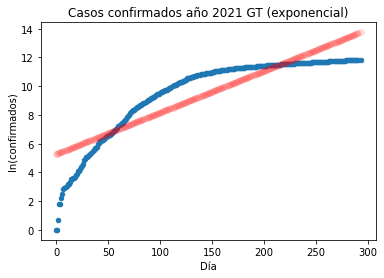

In [20]:
# Visualizando el conjunto original vs las predicciones (exponencial)
dtCovidGT.plot.scatter(x = 'no_dia', y = 'ln(confirmados)')
plt.scatter(x = dtCovidGT['no_dia'], y = predicciones, color = 'red', alpha = 0.1)
plt.title('Casos confirmados año 2021 GT (exponencial)')
plt.xlabel('Día')
plt.show()

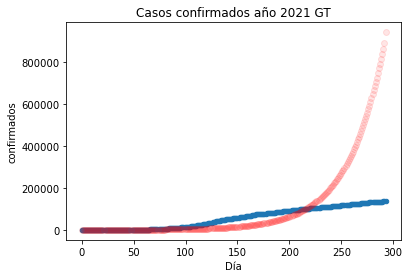

In [21]:
# Visualizando el conjunto original vs las predicciones (sin exponencial)
dtCovidGT.plot.scatter(x = 'no_dia', y = 'confirmados')
plt.scatter(x = dtCovidGT['no_dia'], y = np.exp(predicciones), color = 'red', alpha = 0.1)
plt.title('Casos confirmados año 2021 GT')
plt.xlabel('Día')
plt.show()

**Nota:** para la predicción del día 31 de mayo de 2021, se establece que el número de día a partir del día **0** es el **443**

In [22]:
# Calculando predicciones para 31 de mayo
rango = np.linspace(0,443, 443)
predicciones_may = parametros[0][0][0] * np.exp(rango) + parametros[0][0][1]

predicciones_may[-1]

7.143838274539002e+190

### Conclusiones

1. Con base a los datos seleccionados del año 2020, se nota claramente una tendencia no lineal, por lo cual predecir datos a través del establecimiento de un modelo de regresión lineal no es la mejora solución.

2. El mejor modelo dimensional es el **h(x) =  0.028938508 x + 5.2771063** con lr =0.00007 y epoch = 4000,000

3. Al verificar la curva de predicciones vs los datos originales se puede constatar que las predicciones siguen otra tendencia muy distinta a los datos originales, por lo cual no es el mejor modelo para predecir la cantidad de persona confirmadas de covid en Guatemala.

4. Se puede observar que los datos confirmados entre el 2020 y 2021 siguen tendencias distintas, por lo cual predecir datos del años 2021 con datos del año 2020 no es la mejor opción.

5. Según el modelo la predicción de infectados para el 31 de mayo de 2021 es 7.143838274539002e+190. (un número que sobre pasa la cantidad de población de Guatemala)

# Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
 
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.


### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:

1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Variable a predecir: 

12. quality (puntuacion  entre 0 y 10) 


In [23]:
data = pd.read_csv('data/winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Análisis exploratorio de los datos

In [24]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### Gráficas de distribución de las variables

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


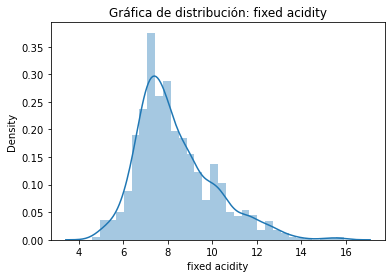

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


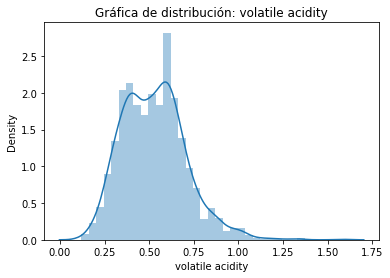

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


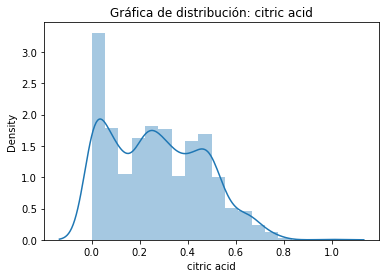

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


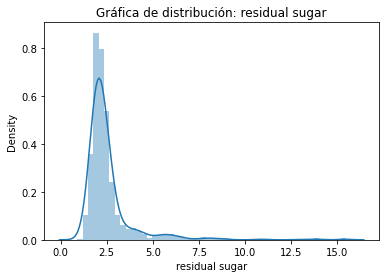

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


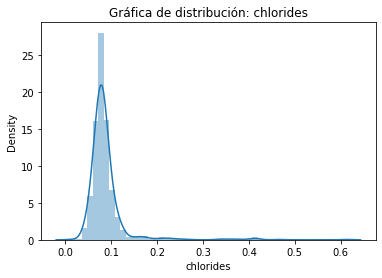

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


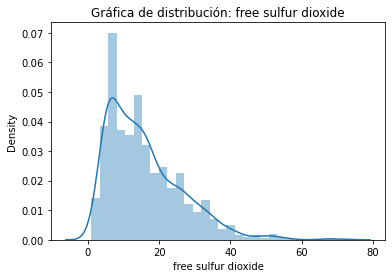

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


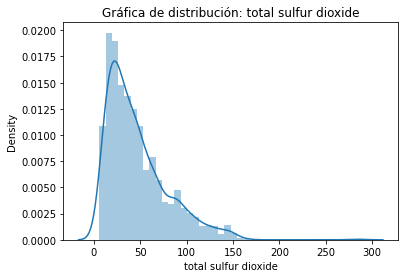

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


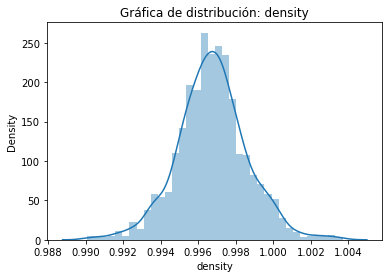

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


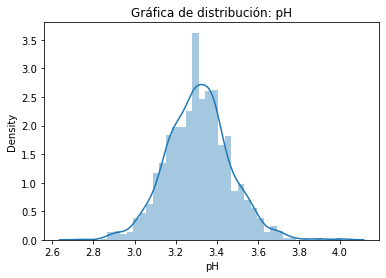

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


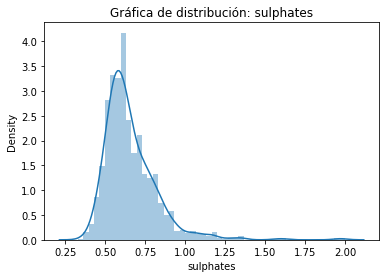

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


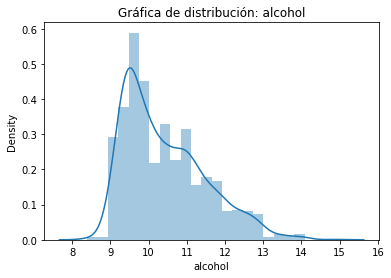

/home/ds/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


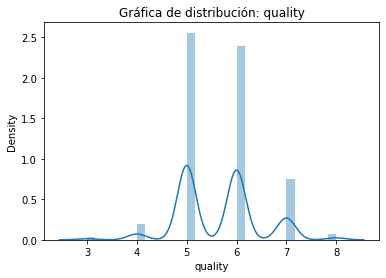

In [25]:
for i in range(0,len(data.columns)):
    nombreVar = str(data.columns[i])
    plotNombre = "Gráfica de distribución: " + nombreVar
    sns.distplot(data[data.columns[i]]).set_title(plotNombre)
    plt.show()

- Con base a las gráficas de distribución se puede indicar que la mayoría de variables independientes se distribuyen o se asemejan a una distribución normal, algunas con sesgo hacia la derecha.

- La variable dependiente **quality** tiene su propia distribución dato que es discreta categórica.

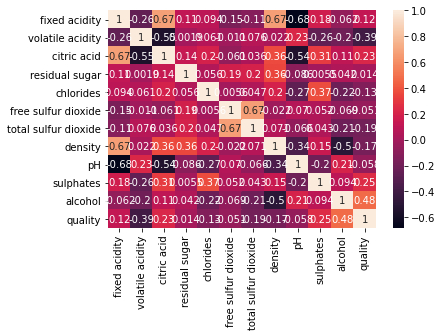

In [26]:
# Encontrando coeficientes de correlación entre la variables y graficándolo

MatrixCorrelacion = data.corr()
sns.heatmap(MatrixCorrelacion, annot=True)
plt.show()

**Al observar las correlaciones se descartarán las variables con correlaciones cercanas a 0**

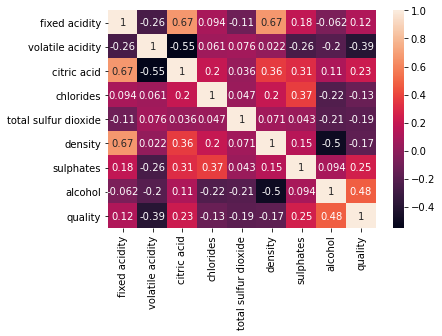

In [27]:
data = data.drop(columns = ['residual sugar', 'free sulfur dioxide', 'pH'])
MatrixCorrelacion = data.corr()
sns.heatmap(MatrixCorrelacion, annot=True)
plt.show()

**Nota:** Con base a la gráfica de correlación se tomarán las variables con correlación mayor (valor absoluto) siendo estas: **alcohol, sulphates y volatile acidity**.

## Modelo de regresión polinomial con Tensor Flow

Para el modelo de regresión polinomial se usará Gradient Descent

In [28]:
# Dividiendo datos para entrenamiento y test
data = data.sample(frac = 1)
index = int(0.8 * len(data))
df_train = data[:index]
df_test = data[:-index]

In [29]:
# MRP = modelo de regresión polinomial
class MRP:
    
    # Constructor de clase para la inicialización de los parámetros
    def __init__ (self, Nvariables):
        self.parametros = tf.get_variable("parametros", dtype = tf.float32, shape = [1,Nvariables], initializer = tf.zeros_initializer())
    
    # Cálculo de MSE
    def MSE(self, x, y):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - tf.matmul(self.parametros,x)))
        return error

    # Cálculo de  gradient descent
    def gradient_descent(self, xt, yt, xtst, ytst, lr):
        mse_train = self.MSE(xt,yt)
        error_summary_train = tf.summary.scalar("mse_summary_train", mse_train)

        mse_test = self.MSE(xtst,ytst)
        error_summary_test = tf.summary.scalar("mse_summary_test", mse_test)

        
        gradiente = tf.gradients(mse_train, [self.parametros])
        new_w = tf.assign(self.parametros, self.parametros -lr * gradiente[0])
        return new_w, mse_train, mse_test, error_summary_train, error_summary_test

In [30]:
# Función de entrenamiento
def training_modelPoly(var_train, y_train, var_test, y_test, grado, lr, epochs, printl):
    
    # String para experimento
    directory = './gWine/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs) + "_polydegree=" + str(grado)
    
    # Usando sklearn para definir el modelo polinomial
    from sklearn.preprocessing import PolynomialFeatures
    xtrain = PolynomialFeatures(grado).fit_transform(var_train)
    xtest = PolynomialFeatures(grado).fit_transform(var_test)

    n_variables = xtrain.shape[1]
    n_rows = xtrain.shape[0]
    n_rowstest = xtest.shape[0]
   
    # Definición del grafo
    graph = tf.Graph()  
    with graph.as_default():
        
        # Creación de los tensores input
        t_xtrain = tf.placeholder(tf.float32, [n_variables, n_rows], "tr_xtrain")
        t_ytrain = tf.placeholder(tf.float32, [n_rows], "tr_ytrain")
        t_xtest = tf.placeholder(tf.float32, [n_variables, n_rowstest], "t_xtest")
        t_ytest = tf.placeholder(tf.float32, [n_rowstest], "t_ytest")
        
        
        # Creación del nodo para el cálculo de los nuevos parámetros según gradient_descent
        mrp = MRP(n_variables)
        nuevos_parametros = mrp.gradient_descent(t_xtrain, t_ytrain, t_xtest, t_ytest, lr)
        
                
        # Escribiendo para tensorboard
        writer = tf.summary.FileWriter(directory, graph)
        
        # Ejecución del grafo
        with tf.train.MonitoredSession() as session:
            # Paso de valores a los tensores input
            feed_dict = {t_xtrain:xtrain.T, t_ytrain:ytrain, t_xtest:xtest.T, t_ytest:ytest}
            
            # Ejecución de epochs + 1 veces del algoritmo
            for i in range(epochs + 1):
                
                # Entrenamiento del modelo para cálculo de los nuevos parámetros
                entrenamiento = session.run(nuevos_parametros, feed_dict = feed_dict)
                # Imprimiendo los epoch según el printl
                if i % printl == 0:
                    parametros = session.run(mrp.parametros, feed_dict = feed_dict)
                    # Escribiendo para tensorboard
                    writer.add_summary(entrenamiento[3], i)
                    writer.add_summary(entrenamiento[4], i)
                    
                    print("Epoch: ", i, "mse_train: ", entrenamiento[1], "mse_test: ", entrenamiento[2])
                                       
            return parametros, entrenamiento[1], entrenamiento[2]
        
        writer.close()

## Cálculo de experimentos

In [31]:
# Preparando X y Y para entrenar modelo
var_train = df_train[['sulphates','volatile acidity', 'alcohol']]
var_test= df_test[['sulphates','volatile acidity', 'alcohol']]
ytrain = df_train['quality']
ytest = df_test['quality']

#### Grado 2

In [32]:
# Experimento 1 (grado 2)
training_modelPoly(var_train, ytrain, var_test, ytest, 2, 0.1, 10, 1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  26103778.0
Epoch:  1 mse_train:  25542534.0 mse_test:  42423934000000.0
Epoch:  2 mse_train:  41511845000000.0 mse_test:  6.894759e+19
Epoch:  3 mse_train:  6.7465255e+19 mse_test:  1.12053935e+26
Epoch:  4 mse_train:  1.0964485e+26 mse_test:  1.8211063e+32
Epoch:  5 mse_train:  1.7819536e+32 mse_test:  inf
Epoch:  6 mse_train:  inf mse_test:  inf
Epoch:  7 mse_train:  inf mse_test:  inf
Epoch:  8 mse_train:  inf mse_test:  inf
Epoch:  9 mse_train:  inf mse_test:  inf
Epoch:  10 mse_train:  inf mse_test:  inf


(array([[6.2149625e+30, 4.1231110e+30, 3.2310069e+30, 6.6144437e+31,
         2.9058877e+30, 2.0966825e+30, 4.3999440e+31, 1.8754943e+30,
         3.4108752e+31, 7.1216176e+32]], dtype=float32),
 inf,
 inf)

In [33]:
# Experimento 2 (grado 2)
training_modelPoly(var_train, ytrain, var_test, ytest, 2, 0.001, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  2222.6606
Epoch:  10 mse_train:  4.0113103e+22 mse_test:  5.6678486e+24
Epoch:  20 mse_train:  inf mse_test:  inf
Epoch:  30 mse_train:  inf mse_test:  inf
Epoch:  40 mse_train:  nan mse_test:  nan
Epoch:  50 mse_train:  nan mse_test:  nan
Epoch:  60 mse_train:  nan mse_test:  nan
Epoch:  70 mse_train:  nan mse_test:  nan
Epoch:  80 mse_train:  nan mse_test:  nan
Epoch:  90 mse_train:  nan mse_test:  nan
Epoch:  100 mse_train:  nan mse_test:  nan


(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32),
 nan,
 nan)

In [34]:
# Experimento 3 (grado 2)
training_modelPoly(var_train, ytrain, var_test, ytest, 2, 0.0001, 100000, 10000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  1.8821726
Epoch:  10000 mse_train:  0.2567463 mse_test:  0.27174094
Epoch:  20000 mse_train:  0.2231629 mse_test:  0.23467925
Epoch:  30000 mse_train:  0.21552931 mse_test:  0.22581129
Epoch:  40000 mse_train:  0.21371451 mse_test:  0.2234092
Epoch:  50000 mse_train:  0.21321021 mse_test:  0.22264531
Epoch:  60000 mse_train:  0.21300231 mse_test:  0.22234038
Epoch:  70000 mse_train:  0.21286254 mse_test:  0.22218227
Epoch:  80000 mse_train:  0.21273968 mse_test:  0.22207852
Epoch:  90000 mse_train:  0.21262212 mse_test:  0.22199643
Epoch:  100000 mse_train:  0.21250716 mse_test:  0.22193031


(array([[ 0.13635159,  0.03802449,  0.02227181,  0.74186146, -0.11285335,
         -0.01598317,  0.08668149, -0.02185888, -0.11765468, -0.01956503]],
       dtype=float32),
 0.21250716,
 0.22193031)

#### Grado 3

In [35]:
# Experimento 4 (grado 3)
training_modelPoly(var_train, ytrain, var_test, ytest, 3, 0.1, 10, 1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  366291160000.0
Epoch:  1 mse_train:  353684850000.0 mse_test:  8.609422e+21
Epoch:  2 mse_train:  8.313035e+21 mse_test:  2.023564e+32
Epoch:  3 mse_train:  1.9539005e+32 mse_test:  inf
Epoch:  4 mse_train:  inf mse_test:  inf
Epoch:  5 mse_train:  inf mse_test:  inf
Epoch:  6 mse_train:  inf mse_test:  inf
Epoch:  7 mse_train:  inf mse_test:  inf
Epoch:  8 mse_train:  inf mse_test:  nan
Epoch:  9 mse_train:  nan mse_test:  nan
Epoch:  10 mse_train:  nan mse_test:  nan


(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]], dtype=float32),
 nan,
 nan)

In [36]:
# Experimento 5 (grado 3)
training_modelPoly(var_train, ytrain, var_test, ytest, 3, 0.001, 100, 10)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  16.575
Epoch:  10 mse_train:  inf mse_test:  inf
Epoch:  20 mse_train:  nan mse_test:  nan
Epoch:  30 mse_train:  nan mse_test:  nan
Epoch:  40 mse_train:  nan mse_test:  nan
Epoch:  50 mse_train:  nan mse_test:  nan
Epoch:  60 mse_train:  nan mse_test:  nan
Epoch:  70 mse_train:  nan mse_test:  nan
Epoch:  80 mse_train:  nan mse_test:  nan
Epoch:  90 mse_train:  nan mse_test:  nan
Epoch:  100 mse_train:  nan mse_test:  nan


(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]], dtype=float32),
 nan,
 nan)

In [37]:
# Experimento 6 (grado 3)
training_modelPoly(var_train, ytrain, var_test, ytest, 3, 0.0001, 20000, 2000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  16.575
Epoch:  2000 mse_train:  nan mse_test:  nan
Epoch:  4000 mse_train:  nan mse_test:  nan
Epoch:  6000 mse_train:  nan mse_test:  nan
Epoch:  8000 mse_train:  nan mse_test:  nan
Epoch:  10000 mse_train:  nan mse_test:  nan
Epoch:  12000 mse_train:  nan mse_test:  nan
Epoch:  14000 mse_train:  nan mse_test:  nan
Epoch:  16000 mse_train:  nan mse_test:  nan
Epoch:  18000 mse_train:  nan mse_test:  nan
Epoch:  20000 mse_train:  nan mse_test:  nan


(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]], dtype=float32),
 nan,
 nan)

In [38]:
# Experimento 6 (grado 3)
training_modelPoly(var_train, ytrain, var_test, ytest, 3, 0.00001, 20000, 2000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  16.575
Epoch:  2000 mse_train:  nan mse_test:  nan
Epoch:  4000 mse_train:  nan mse_test:  nan
Epoch:  6000 mse_train:  nan mse_test:  nan
Epoch:  8000 mse_train:  nan mse_test:  nan
Epoch:  10000 mse_train:  nan mse_test:  nan
Epoch:  12000 mse_train:  nan mse_test:  nan
Epoch:  14000 mse_train:  nan mse_test:  nan
Epoch:  16000 mse_train:  nan mse_test:  nan
Epoch:  18000 mse_train:  nan mse_test:  nan
Epoch:  20000 mse_train:  nan mse_test:  nan


(array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]], dtype=float32),
 nan,
 nan)

#### Grado 1

In [39]:
# Experimento 7 (grado 1)
training_modelPoly(var_train, ytrain, var_test, ytest, 1, 0.1, 10, 1)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  16.575
Epoch:  1 mse_train:  1644.7822 mse_test:  1660.2415
Epoch:  2 mse_train:  168962.16 mse_test:  170680.2
Epoch:  3 mse_train:  17359582.0 mse_test:  17534756.0
Epoch:  4 mse_train:  1783569500.0 mse_test:  1801580900.0
Epoch:  5 mse_train:  183248570000.0 mse_test:  185098960000.0
Epoch:  6 mse_train:  18827434000000.0 mse_test:  19017551000000.0
Epoch:  7 mse_train:  1934380800000000.0 mse_test:  1953913500000000.0
Epoch:  8 mse_train:  1.9874346e+17 mse_test:  2.0075034e+17
Epoch:  9 mse_train:  2.0419442e+19 mse_test:  2.0625635e+19
Epoch:  10 mse_train:  2.0979471e+21 mse_test:  2.119132e+21


(array([[5.8660137e+09, 3.8814336e+09, 3.0732680e+09, 6.1743129e+10]],
       dtype=float32),
 2.0979471e+21,
 2.119132e+21)

In [40]:
# Experimento 8 (grado 1)
training_modelPoly(var_train, ytrain, var_test, ytest, 1, 0.001, 10000, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  13.1616535
Epoch:  1000 mse_train:  0.26441935 mse_test:  0.2889914
Epoch:  2000 mse_train:  0.26227507 mse_test:  0.28666502
Epoch:  3000 mse_train:  0.26026118 mse_test:  0.28446263
Epoch:  4000 mse_train:  0.25836903 mse_test:  0.2823766
Epoch:  5000 mse_train:  0.25659043 mse_test:  0.28039938
Epoch:  6000 mse_train:  0.2549178 mse_test:  0.2785246
Epoch:  7000 mse_train:  0.25334412 mse_test:  0.2767459
Epoch:  8000 mse_train:  0.2518629 mse_test:  0.27505726
Epoch:  9000 mse_train:  0.25046793 mse_test:  0.27345338
Epoch:  10000 mse_train:  0.24915361 mse_test:  0.2719291


(array([[ 0.21833043,  0.33556366, -0.20595217,  0.5086957 ]],
       dtype=float32),
 0.24915361,
 0.2719291)

In [41]:
# Experimento 9 (grado 1)
training_modelPoly(var_train, ytrain, var_test, ytest, 1, 0.0001, 10000, 1000)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch:  0 mse_train:  16.27287 mse_test:  16.21562
Epoch:  1000 mse_train:  0.26646844 mse_test:  0.2911995
Epoch:  2000 mse_train:  0.26623493 mse_test:  0.29094693
Epoch:  3000 mse_train:  0.266003 mse_test:  0.29069775
Epoch:  4000 mse_train:  0.2657725 mse_test:  0.29044992
Epoch:  5000 mse_train:  0.26554343 mse_test:  0.29020348
Epoch:  6000 mse_train:  0.26531583 mse_test:  0.28995842
Epoch:  7000 mse_train:  0.2650897 mse_test:  0.2897147
Epoch:  8000 mse_train:  0.26486504 mse_test:  0.2894724
Epoch:  9000 mse_train:  0.26464176 mse_test:  0.28923142
Epoch:  10000 mse_train:  0.26441985 mse_test:  0.2889917


(array([[ 0.06781575,  0.0687725 , -0.00055391,  0.52954507]],
       dtype=float32),
 0.26441985,
 0.2889917)

In [ ]:
%tensorboard --logdir ./gWine

### Conclusiones

1. Las variables más significativa que pueden explicar la calidad del vino son **'sulphates','volatile acidity', 'alcohol'**

2. Se realizaron 9 experimentos con modelo de 3 variables y grado 1, 2 y 3 respectivamente. Se obtuvieron los siguientes resultados.

- Grado 1 error = 0.2719291 lr = 0.001 epochs = 10000
- Grado 2 error = 0.22193031 lr = 0.00001 epochs = 100000
- Grado 3 no convergió

3. El modelo sugerido con base al error en test es el de Grado 2 con 3 variables, un lr = 0.00001 y epochs = 100000.

4. Podría existir otro modelo que mejore el error en predicción pero por temas de experimentos se llegó hasta grado 3.